# Identify population-enriched genes, plot heatmap

In [1]:
import os,sys
import datetime

### Import scanpy

In [2]:
import scanpy.api as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.3.4 anndata==0.6.13 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
Memory usage: current 0.17 GB, difference +0.17 GB


### Import my utility functions and import statements from github

In [3]:
"""# This cell is run once to download my custom functions and import statements from github

!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
    
# github doesn't seem to have an option to download a specific version of the repo from the history.
# So I download my utility functions and save the download time by appending it to the directory name.
# These utility functions to be shared together with the notebook.

toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
newname = "utility_functions_%s"%toappend
print(newname)


# rename the py file with utility functions
os.rename("utility_functions",newname)"""

'# This cell is run once to download my custom functions and import statements from github\n\n!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions\n    \n# github doesn\'t seem to have an option to download a specific version of the repo from the history.\n# So I download my utility functions and save the download time by appending it to the directory name.\n# These utility functions to be shared together with the notebook.\n\ntoappend = datetime.datetime.now().strftime(\'%y%m%d_%Hh%M\')\nnewname = "utility_functions_%s"%toappend\nprint(newname)\n\n\n# rename the py file with utility functions\nos.rename("utility_functions",newname)'

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_190425_11h32"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import
import rz_utility_spring as srz

python version: 3.6.7


# Load data and place into an annData object

In [5]:
!ls data_from_geo

cell_info_8594x25.tsv         injury_barcodes.tsv
control_barcodes.tsv          injury_genes.tsv
control_genes.tsv             injury_loom.loom
control_loom.loom             injury_matrix.mtx
control_matrix.mtx            raw_counts_8594x27998.mtx
gene_names_alphabetically.txt


In [6]:
obspath = 'data_from_geo/cell_info_8594x25.tsv'
countpath = 'data_from_geo/raw_counts_8594x27998.mtx'
genepath = 'data_from_geo/gene_names_alphabetically.txt'

In [7]:
# load cell info
obs = pd.read_csv(obspath,sep='\t',index_col=0)
print(obs.shape)
obs.head()

(8594, 25)


,barcode,condition,total_counts,pass_quality_filters,inj_epithelial,ctr_epithelial,excluded_as_immune_or_mesench,class,population,phase,...,x_control,y_control,x_class3_exploded,y_class3_exploded,x_control_injured,y_control_injured,x_class1_CTR_cell_cyc_removed,y_class1_CTR_cell_cyc_removed,x_class1_INJ_cell_cyc_removed,y_class1_INJ_cell_cyc_removed
0,AAACCTGAGTGCTGCC-1,control,2787,True,False,True,False,class3,ctr_DEEx,G1,...,783.705500,-377.074709,1082.172898,-266.303304,709.78614,-325.505019,NaN,NaN,NaN,NaN
1,AAACCTGAGTGGGTTG-1,control,3325,True,False,True,False,class3,ctr_upper_IEE,G1,...,709.612642,-429.409941,854.230866,-454.025809,529.15516,-471.961493,NaN,NaN,NaN,NaN
2,AAACCTGCAAGTCTAC-1,control,1781,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AAACCTGCAATCTGCA-1,control,3468,True,False,False,True,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AAACCTGCACGGTGTC-1,control,1745,False,False,False,False,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# load counts
adata = sc.read_mtx(countpath)
print(adata.shape)

# add genes (annotation of variables)
adata.var['genes'] = np.loadtxt(genepath,dtype=str)

# make sure var names are genes
adata.var_names = adata.var['genes'].values

# add obs (annotation of observations)
adata.obs = obs

# make sure index is unique AND a string
adata.obs_names_make_unique()
adata.obs_names = adata.obs_names.astype(str)

(8594, 27998)


### Scale (normalize) data

In [9]:
# turn into counts per 10k
print(adata.X[:5,:].sum(axis=1))
print()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
print(adata.X[:5,:].sum(axis=1))

[[2787.]
 [3325.]
 [1781.]
 [3468.]
 [1745.]]

[[10000.   ]
 [10000.   ]
 [10000.001]
 [10000.   ]
 [ 9999.999]]


### Functions

In [10]:
# I should move this function to rz_functions.py eventually
def get_fc_to_all_other(
    lab,
    meta,
    E,
    pseudo,
    gene_list,
    print_progression = False,
    ):
    
    """
    For each cluster i, find fold-change of a gene in i vs all other cells.
    
    input:
        lab - meta column name to group cell by
        meta - meta dataframe, cells x features
        E - sparse counts, cells x genes, same nr cells as meta
        pseudo - pseudovalue to add
        gene_list - gene list, matches the nr columns of E
        
    output:
        dictionary with cluster names as keys, and pd.Series of genes
        and their fold-change in cluster vs all other cells/
    
    example of use:
        
        
        fcdict = get_fc_to_all_other(
        lab = thelabel,
        meta = meta[cellmask_to_use],
        E = Enorm[cellmask_to_use,:],
        pseudo = pseudo,
        gene_list = gene_list
        )
    
    
    """
    
    resdict = {}
    
    for cl in meta[lab].unique():
        mask = (meta[lab] == cl).values
        maskinv = ~mask

        # selected cells
        left = np.array(E[mask,:].todense())

        # all other cells
        right = np.array(E[maskinv,:].todense())

        # fold-change
        fc = pd.Series((left.mean(axis=0)+pseudo)/(right.mean(axis=0)+pseudo),index=gene_list)
        resdict[cl] = fc
        
        if print_progression:
            print(cl)

    return resdict

# rename for easy code recycling once I move
# the function to 
rz.get_fc_to_all_other = get_fc_to_all_other
del get_fc_to_all_other

### Mkdir for outputs

In [21]:
outdir = 'outputs/population_enriched_genes_control/'
#!mkdir -p $outdir

# Get enriched genes

In [11]:
cmask = adata.obs['ctr_epithelial'].astype(bool).values
print(cmask.sum())

2349


In [12]:
# get centroids
thelabel = 'population'
centroids = rz.centroids(thelabel,adata[cmask])

In [13]:
# For each cluster, find genes that are statistically significantly higher or lower in cluster x compared to
# all other cells collectively

#label-free filter to remove very low abundance genes:
min_counts = 6
min_cells = 3

In [14]:
gmask = srz.filter_abund_genes(adata.X[cmask], min_counts, min_cells)

6151 genes passing abundance filter


In [15]:
mwu_dict = {}
start=time.time()
counter=0

meta = adata[cmask].obs
E = adata[cmask].X
gene_list = adata.var_names


for cluster in meta[thelabel].unique():
    counter+=1
    mask1 = (meta[thelabel]==cluster).values
    mask2 = mask1==False
    
    cg1 = np.array(E[:,gmask][mask1,:].todense())
    cg2 = np.array(E[:,gmask][mask2,:].todense())
    mwu_dict[cluster] = rz.mwu(cg1,cg2,genes=gene_list[gmask],print_progression=True)
    print("%d/%d"%(counter,len(meta[thelabel].unique())))
    print(cluster, 'done',cg1.shape[0]+cg2.shape[0])
print(time.time()-start)

fname = 'backups/cluster_vs_rest_MWU_result_dict_%s'%rz.now()
print(fname)
#rz.save_stuff(mwu_dict,fname)

1000
2000
3000
4000
5000
6000
1/15
ctr_DEEx done 2349
1000
2000
3000
4000
5000
6000
2/15
ctr_upper_IEE done 2349
1000
2000
3000
4000
5000
6000
3/15
ctr_M_G1 done 2349
1000
2000
3000
4000
5000
6000
4/15
ctr_OEE_IEE done 2349
1000
2000
3000
4000
5000
6000
5/15
ctr_G2_M done 2349
1000
2000
3000
4000
5000
6000
6/15
ctr_OEE_2 done 2349
1000
2000
3000
4000
5000
6000
7/15
ctr_OSR done 2349
1000
2000
3000
4000
5000
6000
8/15
ctr_SI done 2349
1000
2000
3000
4000
5000
6000
9/15
ctr_S done 2349
1000
2000
3000
4000
5000
6000
10/15
ctr_VEE done 2349
1000
2000
3000
4000
5000
6000
11/15
ctr_pre_AMB done 2349
1000
2000
3000
4000
5000
6000
12/15
ctr_OEE_1 done 2349
1000
2000
3000
4000
5000
6000
13/15
ctr_AMB_dist done 2349
1000
2000
3000
4000
5000
6000
14/15
ctr_AMB_prox done 2349
1000
2000
3000
4000
5000
6000
15/15
ctr_ISR_SI done 2349
43.596296310424805
backups/cluster_vs_rest_MWU_result_dict_190428_15h55


In [27]:
# if continuing from backup
#mwu_dict = rz.load_stuff('backups/cluster_vs_rest_MWU_result_dict_190428_15h55.pickle')

In [16]:
# select pseudovalue to add
pseudo = 1 # 1 counts per 10k

In [17]:
print(thelabel)
fcdict = rz.get_fc_to_all_other(
        lab = thelabel,
        meta = adata[cmask].obs,
        E = adata[cmask].X,
        pseudo = pseudo,
        gene_list = adata.var_names,
        )

population


In [18]:
# leave only genes with a significant difference.
fcdictsig = {}

# before the mwu test, I prefiltered genes on abundance, apply this mask here as well
print(gmask.sum())
for key,value in fcdict.items():
    sigmask = (mwu_dict[key]['fdr']<0.05).values
    fcdictsig[key] = value[gmask][sigmask]
    print(key,sigmask.sum(),len(fcdictsig[key]))

6151
ctr_DEEx 679 679
ctr_upper_IEE 759 759
ctr_M_G1 1107 1107
ctr_OEE_IEE 862 862
ctr_G2_M 3951 3951
ctr_OEE_2 1953 1953
ctr_OSR 1432 1432
ctr_SI 498 498
ctr_S 2201 2201
ctr_VEE 1394 1394
ctr_pre_AMB 1579 1579
ctr_OEE_1 460 460
ctr_AMB_dist 909 909
ctr_AMB_prox 1751 1751
ctr_ISR_SI 1096 1096


In [19]:
# nr genes to consider:
#upto = 100 # up to 100 genes used to generate Table S1
upto = 20

frame = {}
for key,value in fcdictsig.items():
    s = value.sort_values(ascending=False)[:upto]
    key2 = str(key)+'_FC'
    frame[str(key)] = s.index
    frame[key2] = s.values
frame = pd.DataFrame(frame)
frame[[i for i in frame.columns if "FC" in i]].min() #ok, all above 1.

ctr_DEEx_FC         1.778278
ctr_upper_IEE_FC    1.506326
ctr_M_G1_FC         1.722755
ctr_OEE_IEE_FC      2.042661
ctr_G2_M_FC         3.478086
ctr_OEE_2_FC        3.055256
ctr_OSR_FC          2.372641
ctr_SI_FC           2.039897
ctr_S_FC            2.109731
ctr_VEE_FC          3.307129
ctr_pre_AMB_FC      1.893390
ctr_OEE_1_FC        2.940244
ctr_AMB_dist_FC     5.880776
ctr_AMB_prox_FC     5.283515
ctr_ISR_SI_FC       2.565630
dtype: float32

In [24]:
fname = outdir+'lists_enriched_genes_top_%d_%s_%s.xlsx'%(upto,thelabel,rz.now())
print(fname)
#frame.to_excel(fname)

outputs/population_enriched_genes_control/lists_enriched_genes_top_20_population_190428_15h58.xlsx


In [25]:
clnames = sorted(fcdictsig.keys())
clnames

['ctr_AMB_dist',
 'ctr_AMB_prox',
 'ctr_DEEx',
 'ctr_G2_M',
 'ctr_ISR_SI',
 'ctr_M_G1',
 'ctr_OEE_1',
 'ctr_OEE_2',
 'ctr_OEE_IEE',
 'ctr_OSR',
 'ctr_S',
 'ctr_SI',
 'ctr_VEE',
 'ctr_pre_AMB',
 'ctr_upper_IEE']

In [26]:
# select only columns with gene names:
genes = frame[clnames].values.flatten()
print(len(genes))

# I anticipate some genes to be repeated
genes = rz.oset(genes)
print(len(genes))

# select centroids expression data
heat = centroids[genes].copy()

# transform:
heat = heat + pseudo
heat = heat/heat.median()
heat = np.log2(heat)

#transpose
heat = heat.T

#hierarchically cluster
hierdict = rz.hier_cluster(heat,method='average',metric='correlation')

print(hierdict.keys())

heat = hierdict['data']

300
236
dict_keys(['data', 'row_link', 'col_link'])


### Heatmap

In [27]:
# select gene names to print in the heatmap
totick = [
    
    'Ccnb1','Birc5',
    'Igfbpl1','Ank2',
    'Mmp20','Clu',
    'Cldn10','Pthlh',
    'Tacstd2','Krt17',
    'Enpp2','Hes1',
    'Krt15','Sparcl1',
    'Dcn','Igfbp2'
    
]

-2.431777 7.691111
heatmap_population_upto_20_190428_15h59


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


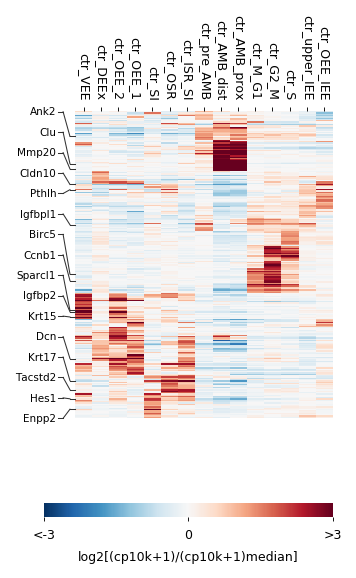

In [28]:
a,fig,gs = rz.startfig(1+heat.shape[1]/3.,4+heat.shape[0]/40.,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-3
vmax=3
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
rz.yticks_fancy(a,totick,labels_all = heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'heatmap_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=600)

outputs/dendrogram_population_190428_15h59.pdf


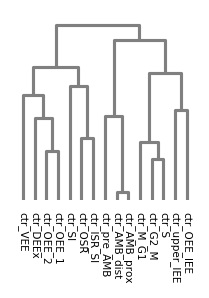

In [29]:
a,fig,gs = rz.startfig(3.5,5)
col_link = hierdict['col_link']
dendro = scipy.cluster.hierarchy.dendrogram(
                                 col_link, orientation='top', ax=a,
                                 above_threshold_color='0.5',
                                 color_threshold = 0,
                                    )

a.set_xticklabels(heat.columns,rotation=270,fontsize=5)
a.set_yticks([])

rz.showspines(a)

gs.tight_layout(fig)
fname = 'outputs/dendrogram_%s_%s.pdf'%(thelabel,rz.now())
print(fname)
#plt.savefig(fname)

# A version of the SAME heatmap but columns ordered as desired

In [31]:
corder = [
     'ctr_AMB_dist',
     'ctr_AMB_prox',
     'ctr_pre_AMB',
     'ctr_DEEx',
     'ctr_upper_IEE',
     'ctr_OEE_IEE',
     'ctr_S',
     'ctr_M_G1',
     'ctr_G2_M',
     'ctr_SI',
     'ctr_OSR',
     'ctr_ISR_SI',
     'ctr_OEE_1',
     'ctr_VEE',
     'ctr_OEE_2'
]


heat = heat[corder[::-1]]

-2.431777 7.691111
heatmap_custom_order_population_upto_20_190428_16h01


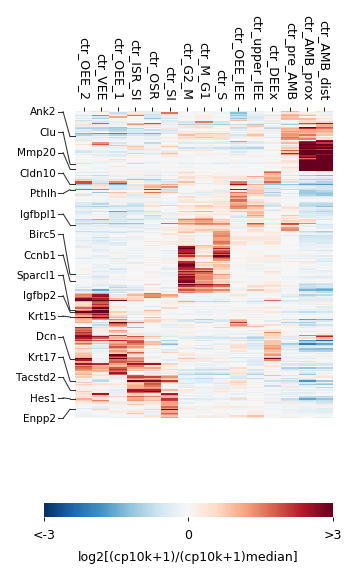

In [32]:
a,fig,gs = rz.startfig(1+heat.shape[1]/3.,4+heat.shape[0]/40.,frameon=False)

cmap = 'RdBu_r'
cbarlabel = 'log2[(cp10k+1)/(cp10k+1)median]'

vmin=-3
vmax=3
print(heat.min().min(),heat.max().max())

# heatmap
hmap = a.imshow(heat,aspect='auto',vmin=vmin,vmax=vmax,cmap=cmap)

# x ticks
a.set_xticks(np.arange(heat.shape[1]))
a.set_xticklabels(heat.columns,rotation=270)
a.xaxis.tick_top()

# y ticks
rz.yticks_fancy(a,totick,labels_all = heat.index)

# colorbar
cbar = fig.colorbar(hmap,orientation='horizontal')
cbar.outline.set_visible(False)

c = [vmin,0,vmax]
clabs = ["<"+str(c[0])]+[str(i) for i in c[1:-1]]+[">"+str(c[-1])]
cbar.set_ticks(c)
cbar.set_ticklabels(clabs)
cbar.set_label(cbarlabel)


gs.tight_layout(fig)
fname = 'heatmap_custom_order_%s_upto_%d_%s'%(thelabel,upto,rz.now())
print(fname)
#plt.savefig(outdir+'%s.pdf'%fname,dpi=600)

In [33]:
# save the pandas dataframe colored as in the heatmap to excel
rz.color_dataframe_cells(heat,vmin=vmin,vmax=vmax,
                         cmap=mpl.cm.get_cmap('RdBu_r'))#.to_excel(outdir+'/heatmap_custom_order_%s.xlsx'%fname)

# Use the MWU results to prepare rnk files for GSEA pre-rank gene set enrichement analysis

In [34]:
# inspire by this blog, I define my ranking as signed-fold-change*(-log10(p))
# http://genomespot.blogspot.com/2014/09/data-analysis-step-8-pathway-analysis.html

rnkdict = {}

for key in mwu_dict.keys():
    
    # foldchange
    fc = (mwu_dict[key]['mean1']+pseudo)/(mwu_dict[key]['mean2']+pseudo)
    
    # signed fold-change
    sfc = fc.apply(lambda x: x if x>1. else -1./x)
    
    # my ranking
    rnk = -np.log10(mwu_dict[key]['p'])*sfc
    
    # sort just in case:
    rnk.sort_values(ascending=False, inplace=True)
    
    # add to dictionary
    rnkdict[key] = rnk

In [35]:
# mousify
# whoops, looks like these are human genes, and I have mouse data
# download a mouse-human orthology table fro mgi
# in general, for this purpose I want to be permissive

#opath = "http://www.informatics.jax.org/downloads/reports/HMD_HumanPhenotype.rpt"
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#!mkdir mouse_human_orthologs
#!cd mouse_human_orthologs && curl -LO $opath
#!echo "Downloaded from $opath \n on $toappend" > mouse_human_orthologs/readme.txt

In [36]:
oframe = pd.read_csv('mouse_human_orthologs/HMD_HumanPhenotype.rpt',sep='\t',header=None)


# for this purpose, I cannot be permissive and have multiple mouse genes mapping one human gene
# as this would lead to repeated genes or ties in the ranking.
# I choose a simple and very stringent translation: only focus on genes that have a 1-to-1 match

dupmask1 = ~oframe[4].duplicated(keep=False)
dupmask2 = ~oframe[0].duplicated(keep=False)

dupmask = dupmask1&dupmask2
print(dupmask.shape,dupmask.sum(),dupmask1.sum(),dupmask2.sum())

# human to mouse dictionary
m2h = {i:j for i,j in zip(oframe[4][dupmask],oframe[0][dupmask])}

# double-check that unique translations
print(len(m2h)==len(set(m2h.keys())))
print(len(m2h)==len(set(m2h.values())))

(18747,) 17634 18270 17806
True
True


In [49]:
oframe = pd.read_csv('mouse_human_orthologs/HMD_HumanPhenotype.rpt',sep='\t',header=None)


# for this purpose, I cannot be permissive and have multiple mouse genes mapping one human gene
# as this would lead to repeated genes or ties in the ranking.
# I choose a simple and very stringent translation: only focus on genes that have a 1-to-1 match

dupmask1 = ~oframe[4].duplicated(keep=False)
dupmask2 = ~oframe[0].duplicated(keep=False)

dupmask = dupmask1&dupmask2
print(dupmask.shape,dupmask.sum(),dupmask1.sum(),dupmask2.sum())

# human to mouse dictionary
m2h = {i:j for i,j in zip(oframe[4][dupmask],oframe[0][dupmask])}

# double-check that unique translations
print(len(m2h)==len(set(m2h.keys())))
print(len(m2h)==len(set(m2h.values())))



(18390,) 17291 17923 17453
True
True


In [37]:
# humanize the ranking results:
hrnkdict = {}
cantranslate = list(m2h.keys())
for key,value in rnkdict.items():
    nval = value.copy()
    gmask = np.in1d(nval.index,cantranslate)
    print(key,gmask.sum(),gmask.shape)
    
    
    nval = nval[gmask]
    nval.index = [m2h[i] for i in nval.index]
    
    hrnkdict[key] = nval

ctr_DEEx 5765 (6151,)
ctr_upper_IEE 5765 (6151,)
ctr_M_G1 5765 (6151,)
ctr_OEE_IEE 5765 (6151,)
ctr_G2_M 5765 (6151,)
ctr_OEE_2 5765 (6151,)
ctr_OSR 5765 (6151,)
ctr_SI 5765 (6151,)
ctr_S 5765 (6151,)
ctr_VEE 5765 (6151,)
ctr_pre_AMB 5765 (6151,)
ctr_OEE_1 5765 (6151,)
ctr_AMB_dist 5765 (6151,)
ctr_AMB_prox 5765 (6151,)
ctr_ISR_SI 5765 (6151,)


In [38]:
# save as rnk files:
rankdir = outdir+'GSEA_input/'
#!mkdir -p $rankdir

#for key,value in hrnkdict.items():
#    fname = rankdir+'%s_vs_all.rnk'%(key.replace('/',''))
#    value.to_csv(fname,sep='\t')